In [ ]:
#                                 Fully Convolutional Network (FCN) + LSTM

In [ ]:
#                                                  S. Maishal                                                   06-11-2024

In [ ]:
#                                     Indian Institute of Technology, Kharagpur

In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
netcdf_file = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\CROCO.nc"
ds = xr.open_dataset(netcdf_file)

# Extract data variables
fe = ds['fe'].values  # (time, depth, lat, lon)
po4 = ds['po4'].values
si = ds['si'].values
no3 = ds['no3'].values

# Extract latitude and longitude
latitude = ds['latitude'].values  # Shape: (48,)
longitude = ds['longitude'].values  # Shape: (28,)

# Since depth is constant, discard the depth dimension and focus on (time, lat, lon)
fe = fe[:, 0, :, :]
po4 = po4[:, 0, :, :]
si = si[:, 0, :, :]
no3 = no3[:, 0, :, :]

# Replace NaN values in NO3 with the mean of available values
no3 = np.nan_to_num(no3, nan=np.nanmean(no3))

# Stack the input variables along a new channel dimension (fe, po4, si)
inputs = np.stack([fe, po4, si], axis=-1)  # Shape: (time, lat, lon, channels)

# Prepare input for LSTM
time_steps = 5  # Number of time steps to consider in each sequence
samples = inputs.shape[0] - time_steps
X_lstm = np.array([inputs[i:i + time_steps] for i in range(samples)])
y_lstm = no3[time_steps:]  # Targets start from the time offset

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Normalize the data
scaler_X = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[2] * X_train.shape[3] * X_train.shape[4])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2] * X_test.shape[3] * X_test.shape[4])
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[1] * y_train.shape[2])).reshape(y_train.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[1] * y_test.shape[2])).reshape(y_test.shape)

# Define the FCN + LSTM Model
model = tf.keras.models.Sequential([
    # Apply FCN on each time step
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),  # Flatten spatial dimensions

    # LSTM to process the temporal sequence of spatial features
    tf.keras.layers.LSTM(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1] * y_train.shape[2])  # Output shape is flattened (lat * lon)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled.reshape(y_train_scaled.shape[0], -1), 
                    epochs=50, batch_size=16, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled.reshape(y_test_scaled.shape[0], -1))

# Make predictions
predictions = model.predict(X_test_scaled)
predicted_no3 = scaler_y.inverse_transform(predictions.reshape(-1, y_test.shape[1] * y_test.shape[2])).reshape(y_test.shape)

print("Test Loss:", test_loss)

# Compute average actual and predicted NO3 across time steps
average_actual = np.nanmean(y_test, axis=0)  # Average across time dimension
average_predicted = np.nanmean(predicted_no3, axis=0)  # Average across time dimension

# Define output file path
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\average_no3_output_fcn+lstm.nc"

# Create a new NetCDF file
with xr.Dataset() as ds_out:
    # Create dimensions
    ds_out.coords['latitude'] = ('latitude', latitude)
    ds_out.coords['longitude'] = ('longitude', longitude)

    # Add actual NO3 and predicted NO3 as variables
    ds_out['average_actual_no3'] = (('latitude', 'longitude'), average_actual)
    ds_out['average_predicted_no3'] = (('latitude', 'longitude'), average_predicted)

    # Set attributes for the dataset and variables
    ds_out.attrs['title'] = 'Average NO3 Concentrations (FCN + LSTM)'
    ds_out.attrs['description'] = 'Contains average actual and predicted NO3 concentrations'

    ds_out['average_actual_no3'].attrs['units'] = 'mmol m-3'
    ds_out['average_predicted_no3'].attrs['units'] = 'mmol m-3'

    # Save the dataset to a NetCDF file
    ds_out.to_netcdf(output_file_path)

print(f"Output saved to: {output_file_path}")


C:\Users\Subhadeep Maishal\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


C:\Users\Subhadeep Maishal\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Subhadeep Maishal\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\Subhadeep Maishal\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count





Epoch 1/50

15/15 [==============================] - 11s 449ms/step - loss: 0.4610 - val_loss: 0.5371
Epoch 2/50
15/15 [==============================] - 6s 405ms/step - loss: 0.4609 - val_loss: 0.5373
Epoch 3/50
15/15 [==============================] - 6s 397ms/step - loss: 0.4608 - val_loss: 0.5374
Epoch 4/50
15/15 [==============================] - 6s 402ms/step - loss: 0.4608 - val_loss: 0.5376
Epoch 5/50
15/15 [==============================] - 6s 406ms/step - loss: 0.4608 - val_loss: 0.5378
Epoch 6/50
15/15 [==============================] - 6s 398ms/step - loss: 0.4607 - val_loss: 0.5379
Epoch 7/50
15/15 [==============================] - 6s 394ms/step - loss: 0.4607 - val_loss: 0.5382
Epoch 8/50
15/15 [==============================] - 6s 390ms/step - loss: 0.4607 - val_loss: 0.5382
Epoch 9/50
15/15 [==============================] - 6s 437ms/step - loss: 0.4607 - val_loss: 0.5384
Epoch 10/50
15/15 [==============================] - 7s 448ms/step - loss: 0.4607 - val_loss: 0

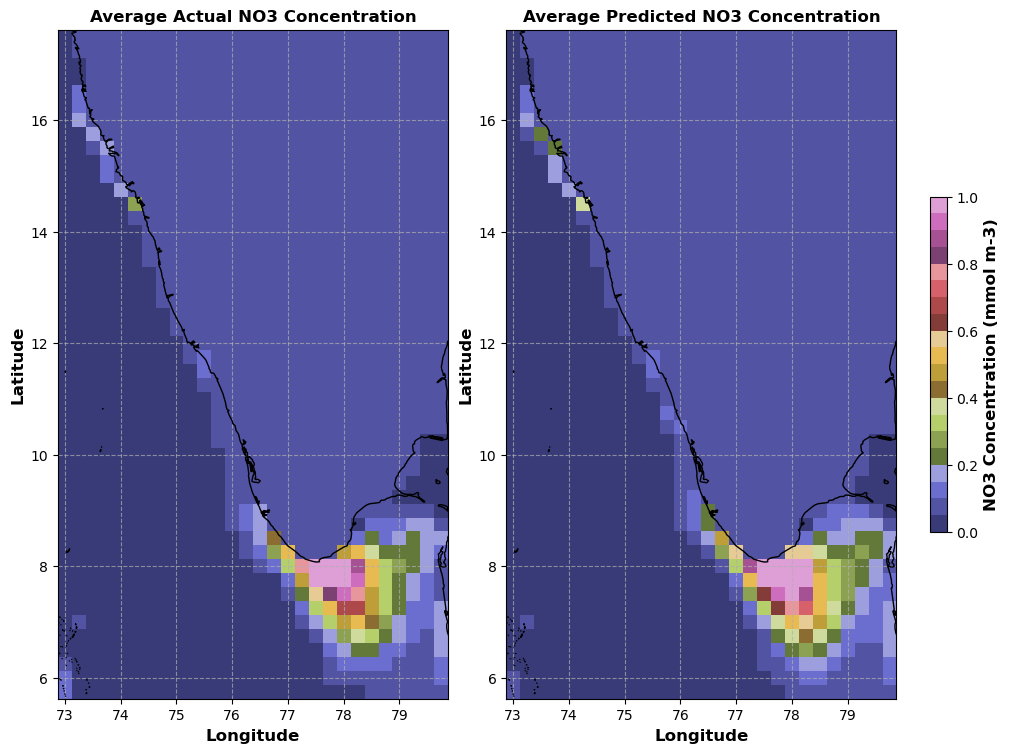

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Define file paths
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\average_no3_output_fcn+lstm.nc"
coastline_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\ne_10m_coastline\ne_10m_coastline.shp"

# Read the NetCDF file using xarray
ds = xr.open_dataset(output_file_path)

# Extract the variables you want to plot
actual_no3 = ds['average_actual_no3']
predicted_no3 = ds['average_predicted_no3']

# Read the coastline shapefile using geopandas
coastline = gpd.read_file(coastline_file_path)

# Create a figure with subplots and set the gap between them
fig, ax = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True, gridspec_kw={'wspace': 0.02})

# Define common vmin and vmax
vmin = 0
vmax = 1.0

# Customize font properties
font_properties = {'fontsize': 12, 'fontweight': 'bold'}

# Plot the average actual NO3 concentration
img1 = actual_no3.plot(ax=ax[0], cmap='tab20b', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[0].set_title('Average Actual NO3 Concentration', **font_properties)
ax[0].set_xlabel('Longitude', **font_properties)
ax[0].set_ylabel('Latitude', **font_properties)
ax[0].grid(True, linestyle='--', alpha=0.7)  # Add grid lines

# Overlay the coastline on the actual NO3 plot
coastline.plot(ax=ax[0], color='black', linewidth=1)

# Plot the average predicted NO3 concentration
img2 = predicted_no3.plot(ax=ax[1], cmap='tab20b', vmin=vmin, vmax=vmax, add_colorbar=False)

ax[1].set_title('Average Predicted NO3 Concentration', **font_properties)
ax[1].set_xlabel('Longitude', **font_properties)
ax[1].set_ylabel('Latitude', **font_properties)
ax[1].grid(True, linestyle='--', alpha=0.7)  # Add grid lines

# Overlay the coastline on the predicted NO3 plot
coastline.plot(ax=ax[1], color='black', linewidth=1)

# Create a single colorbar for both subplots using the last plot's image
cbar = fig.colorbar(img1, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('NO3 Concentration (mmol m-3)', **font_properties)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=10)

# Show the plot
plt.show()

# Close the dataset
ds.close()


In [ ]:
#                                            Cheers!